# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


__Нужно спрогнозировать сразу две величины:__
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.


__Данные индексируются датой и временем получения информации (признак `'date'`). Соседние по времени параметры часто похожи.__

__Описание данных:__
- Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
 - Xanthate — ксантогенат (промотер, или активатор флотации);
 - Sulphate — сульфат (на данном производстве сульфид натрия);
 - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


__Параметры этапов:__
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


__Наименование признаков__

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`



__Возможные значения для блока [этап]:__
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


__Возможные значения для блока [тип_параметра]:__
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики




## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
# отключим некритические предупреждения в коде

warnings.filterwarnings("ignore")

In [3]:
try:
    data_train = pd.read_csv('/Users/alex/Downloads/gold_industry_train.csv')
    data_test = pd.read_csv('/Users/alex/Downloads/gold_industry_test.csv')
    data_full = pd.read_csv('/Users/alex/Downloads/gold_industry_full.csv')
except:
    data_train = pd.read_csv('/datasets/gold_industry_train.csv')
    data_test = pd.read_csv('/datasets/gold_industry_test.csv')
    data_full = pd.read_csv('/datasets/gold_industry_full.csv')

In [4]:
# объявим глобальные переменные

DATA = [data_train, data_test, data_full]
STATE = np.random.RandomState(42)

Взгялнем на каждый из дф'ов, проверим на явные дубликаты, пропуски

In [5]:
# выведим по хеды

display(data_train.head())
display(data_train.shape)

display(data_test.head())
display(data_test.shape)

display(data_full.head())
display(data_full.shape)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


(14579, 87)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


(4860, 53)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


(19439, 87)

In [6]:
print(f'Количество дубликатов в тренеровочной выборке : {data_train.duplicated().sum()}')
print(f'Количество дубликатов в тестовой выборке : {data_test.duplicated().sum()}')
print(f'Количество дубликатов в полном датасете(генеральной выборке) : {data_full.duplicated().sum()}')

Количество дубликатов в тренеровочной выборке : 0
Количество дубликатов в тестовой выборке : 0
Количество дубликатов в полном датасете(генеральной выборке) : 0


In [7]:
print(f'Количество признаков(столбцов) в тренировочной выборке: {len(data_train.columns)}')
print(f'Количество признаков(столбцов) в тестовой выборке: {len(data_test.columns)}')
print(f'Количество признаков(столбцов) в полном датасете(генеральной выборке) выборке: {len(data_full.columns)}')

Количество признаков(столбцов) в тренировочной выборке: 87
Количество признаков(столбцов) в тестовой выборке: 53
Количество признаков(столбцов) в полном датасете(генеральной выборке) выборке: 87


In [8]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


None

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


Промежуточный вывод:
- явные дубликаты не обнаружены
- имеются пропуски
- формат признака 'data' - object - исправим его далее
- количество признаков в 'data_test', меньше чем в генеральной и тренировочной выборках


Проведем __предобработку__

In [11]:
# изменим формат признака 'date' с object на привычный/правильный datetime

for i in (data_train, data_test, data_full):
    i['date'] = pd.to_datetime(i['date'], format='%Y-%m-%d %H:%M:%S')
    print(f'Тип данных в стобце "date" - {i.dtypes["date"]}')

Тип данных в стобце "date" - datetime64[ns]
Тип данных в стобце "date" - datetime64[ns]
Тип данных в стобце "date" - datetime64[ns]


Так как мы знаем, из описания, что __'Соседние по времени параметры часто похожи'__ - заполним пропуски с помощью функции __ffill__ , во всех наших дф'ах

In [12]:
data_train = data_train.ffill(axis = 0)
data_test = data_test.ffill(axis = 0)
data_full = data_full.ffill(axis = 0)

In [13]:
display(data_train.isna().sum())
display(data_test.isna().sum())
display(data_full.isna().sum())

date                      0
rougher.input.feed_au     0
rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_sol    0
                         ..
final.output.recovery     0
final.output.tail_au      0
final.output.tail_ag      0
final.output.tail_pb      0
final.output.tail_sol     0
Length: 87, dtype: int64

date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

date                      0
rougher.input.feed_au     0
rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_sol    0
                         ..
final.output.recovery     0
final.output.tail_au      0
final.output.tail_ag      0
final.output.tail_pb      0
final.output.tail_sol     0
Length: 87, dtype: int64

Проверим правильно ли расчитана эффективность обогащения. Вычеслим ее на обучающей выборке и сравним ее с результатом `rougher.output.recovery`. Найдем __МАЕ__ между нашими расчетами и значением признака.

Формула для расчета эффективности - `Recovery = ((C * (F - T)) / (F * (C - T))) * 100%` , где 
- C — доля золота в концентрате после флотации/очистки, согласно условиям это - `rougher.output.concentrate_au` ;
- F — доля золота в сырье/концентрате до флотации/очистки, согласно условиям это - `rougher.input.feed_au` ;
- T — доля золота в отвальных хвостах после флотации/очистки, согласно условиям это - `rougher.output.tail_au` .

In [14]:
# расчитаем и сравним полученный результат с data_train['rougher.output.recovery']

C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

Recovery = ((C * (F - T)) / (F * (C - T))) * 100

print(f'Средняя абсолютная ошибка равна: {mean_absolute_error(data_train["rougher.output.recovery"], Recovery)}')

Средняя абсолютная ошибка равна: 9.83758577644259e-15


__МАЕ__ получилась очень маленьком, следовательно можно сказать , что эффективность обагощения была расчитана корректно.

__Проанализируем__ признаки, недоступные в тестовой выборке.

In [15]:
display(set(data_train.columns) - set(data_test.columns))

print(f'\nКоличество отсутсвующих фичей в тестовой выборке: {len(set(data_train.columns) - set(data_test.columns))}')

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta


Количество отсутсвующих фичей в тестовой выборке: 34


Вероятнее всего эти данные из будущего, или же просто присланные данные были не полные, в любом случае мы вернемся к этому вопросу чуть позже, на данном этапе нет смысла выравнивать трейн с тестом по столбцам , так как некоторые столбцы нам могу понадобиться для анализа в дальнейшем

__Промежуточный вывод__

На данном этапе, проделанно следующее:
- импортировали нужные нам библиотеки
- загрузили данные, и вывели хеды
- изменили тип данных для столбца "date", в привычный datetime
- проверили данные на наличие явных дублей
- заполнили пропущенные значения 
- проверили правильно ли расчитана эффективность обогащения, вычислили МАЕ

## Анализ данных

__Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах :__   сырье(`rougher.input.feed_...`), в черновом концентрате(`rougher.output.concentrate...`), в концентрате после первой очистки(`primary_cleaner.output.concentrate_...`) и в финальном концентрате(`final.output.concentrate_...`)

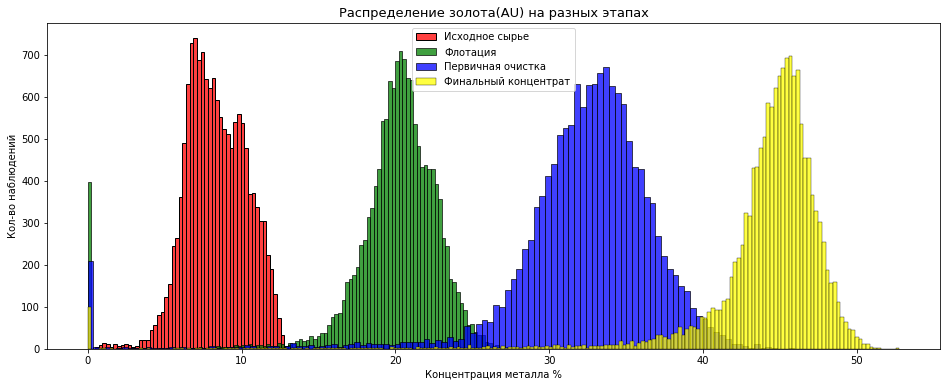

In [16]:
# график распределения золота - Au

plt.figure(figsize = [16, 6])

plt.title(f'Распределение золота(AU) на разных этапах', fontsize = 13)
plt.xlabel('Концентрация металла %')
plt.ylabel('Кол-во наблюдений')

sns.histplot(data_train['rougher.input.feed_au'], color = 'red', label = 'Исходное сырье')
sns.histplot(data_train['rougher.output.concentrate_au'], color = 'green', label = 'Флотация')
sns.histplot(data_train['primary_cleaner.output.concentrate_au'], color = 'blue', label = 'Первичная очистка')
sns.histplot(data_train['final.output.concentrate_au'], color = 'yellow', label = 'Финальный концентрат')

plt.legend()
plt.show()

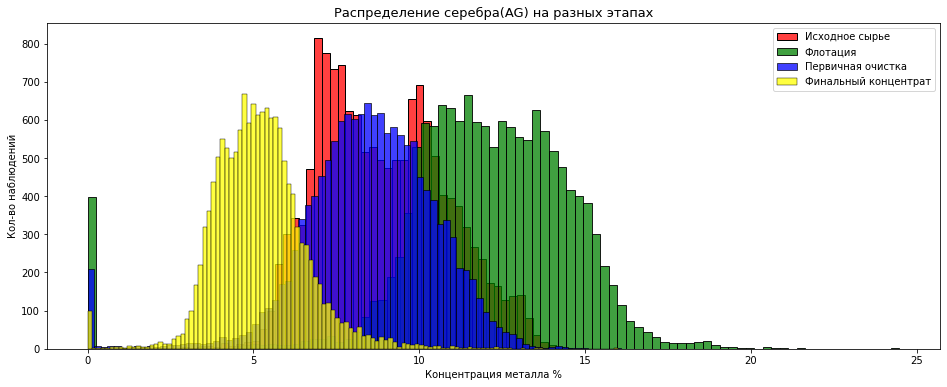

In [17]:
# график распределения серебра - Ag

plt.figure(figsize = [16, 6])

plt.title(f'Распределение серебра(AG) на разных этапах', fontsize = 13)
plt.xlabel('Концентрация металла %')
plt.ylabel('Кол-во наблюдений')

sns.histplot(data_train['rougher.input.feed_ag'], color = 'red', label = 'Исходное сырье')
sns.histplot(data_train['rougher.output.concentrate_ag'], color = 'green', label = 'Флотация')
sns.histplot(data_train['primary_cleaner.output.concentrate_ag'], color = 'blue', label = 'Первичная очистка')
sns.histplot(data_train['final.output.concentrate_ag'], color = 'yellow', label = 'Финальный концентрат')

plt.legend()
plt.show()

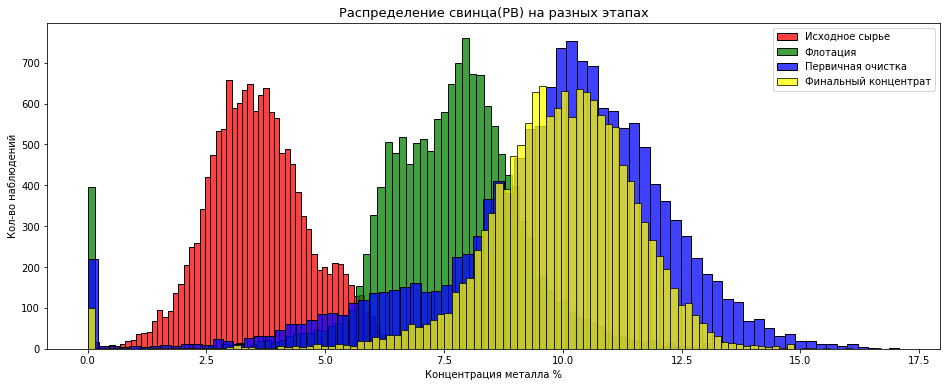

In [18]:
# график распределения свинца - Pb

plt.figure(figsize = [16, 6])

plt.title(f'Распределение свинца(PB) на разных этапах', fontsize = 13)
plt.xlabel('Концентрация металла %')
plt.ylabel('Кол-во наблюдений')

sns.histplot(data_train['rougher.input.feed_pb'], color = 'red', label = 'Исходное сырье')
sns.histplot(data_train['rougher.output.concentrate_pb'], color = 'green', label = 'Флотация')
sns.histplot(data_train['primary_cleaner.output.concentrate_pb'], color = 'blue', label = 'Первичная очистка')
sns.histplot(data_train['final.output.concentrate_pb'], color = 'yellow', label = 'Финальный концентрат')

plt.legend()
plt.show()

In [19]:
# Напишим функцию для удаления аномалий

def data_without_anomaly(data):

    for metal in ['au', 'ag', 'pb']:
        data = data[(data[f'rougher.output.concentrate_{metal}'] > 0.1)]
        data = data[(data[f'final.output.concentrate_{metal}'] > 0.1)]
        data = data[(data[f'primary_cleaner.output.concentrate_{metal}'] > 0.1)]
        data = data[(data[f'final.output.concentrate_{metal}'] > 0.1)]
    return data

In [20]:
# до
print(f'До : {data_train.shape}')

# после
data_train = data_without_anomaly(data_train)
print(f'После : {data_train.shape}')

До : (14579, 87)
После : (13877, 87)


Выведим один из металов, дабы убедиться что аномалии исчезли

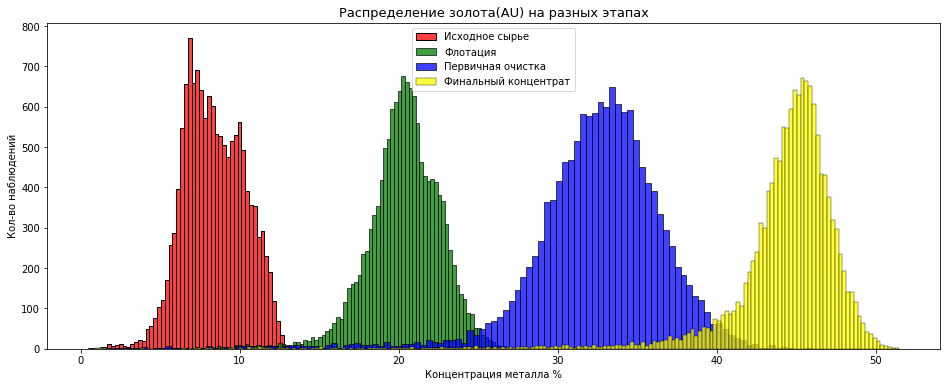

In [21]:
plt.figure(figsize = [16, 6])

plt.title(f'Распределение золота(AU) на разных этапах', fontsize = 13)
plt.xlabel('Концентрация металла %')
plt.ylabel('Кол-во наблюдений')

sns.histplot(data_train['rougher.input.feed_au'], color = 'red', label = 'Исходное сырье')
sns.histplot(data_train['rougher.output.concentrate_au'], color = 'green', label = 'Флотация')
sns.histplot(data_train['primary_cleaner.output.concentrate_au'], color = 'blue', label = 'Первичная очистка')
sns.histplot(data_train['final.output.concentrate_au'], color = 'yellow', label = 'Финальный концентрат')

plt.legend()
plt.show()

От выбрасов избавились, едем дальше

Глядя на графики можно сказать следующее: 
- концентрация золота увеличивается с каждой последующей обработкой
- концентрация серебра увеличивается на этапе флотации, а после очисток концентрация снижается
- концентрация свинца увеличивается после флотации и первичной очистки, финальный концетрат остается приблезительно на уровне как после первичной очистки.

__Сравним распределения размеров гранул исходного сырья `rougher.input.feed_size` на обучающей и тестовой выборках.__


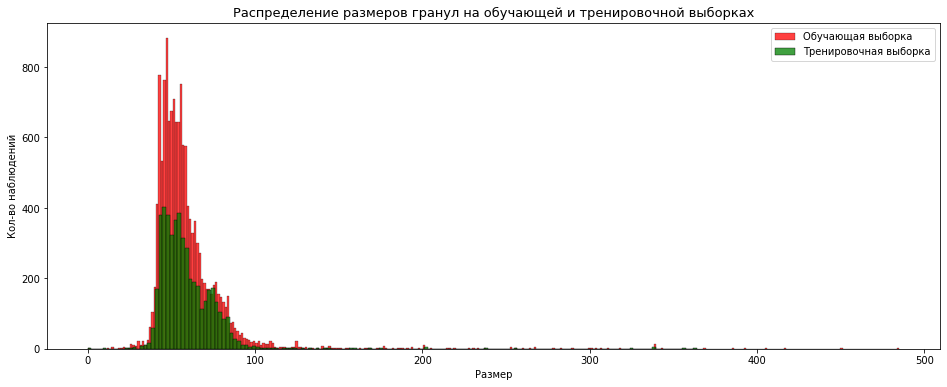

In [22]:
# построим график распределегния гранул

plt.figure(figsize = [16, 6])

plt.title(f'Распределение размеров гранул на обучающей и тренировочной выборках', fontsize = 13)
plt.xlabel('Размер')
plt.ylabel('Кол-во наблюдений')

sns.histplot(data_train['rougher.input.feed_size'], color = 'red', label = 'Обучающая выборка')
sns.histplot(data_test['rougher.input.feed_size'], color = 'green', label = 'Тренировочная выборка')

plt.legend()
plt.show()

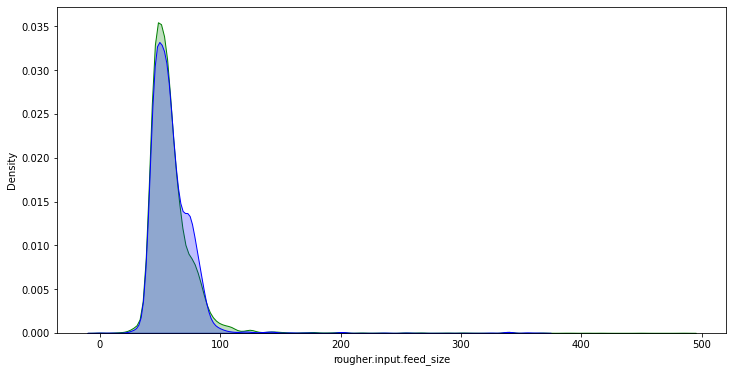

In [23]:
plt.figure(figsize = [12, 6])

sns.kdeplot(data_train['rougher.input.feed_size'], shade = True , color = 'green')
sns.kdeplot(data_test['rougher.input.feed_size'], shade = True , color = 'blue');

Как мы видим из графика, диапозон распределения размера гранул приблезительно одинаковый, однако количество наблюдей в тренировочной выборке больше, что в принципе логично. 

__Исследуйем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.__

In [24]:
# переберем в цикле наши металлы и просумируем, запишем в отдельные переменные

sum_input = 0
sum_output = 0
sum_primary = 0
sum_final = 0
for metal in ['au', 'ag', 'pb']:
    sum_input += data_train[f'rougher.input.feed_{metal}']
    sum_output += data_train[f'rougher.output.concentrate_{metal}']
    sum_primary += data_train[f'primary_cleaner.output.concentrate_{metal}']
    sum_final += data_train[f'final.output.concentrate_{metal}']

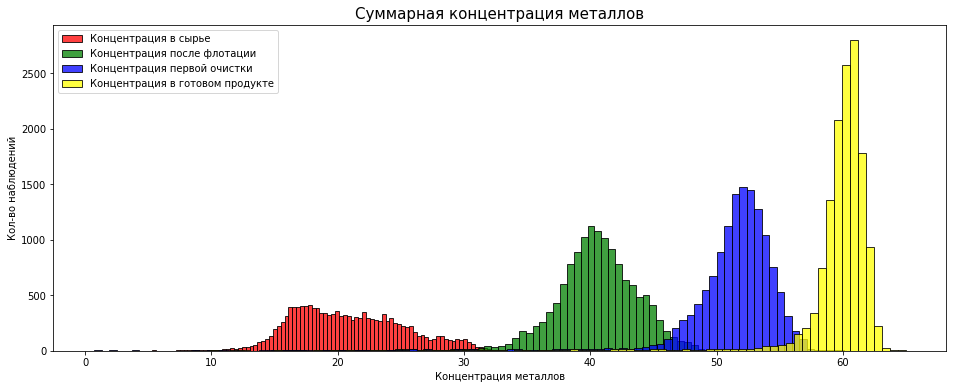

In [25]:
# построим график суммарного распределения концентрации на разных стадиях очистки

plt.figure(figsize=[16, 6])

plt.title('Cуммарная концентрация металлов', fontsize=15)
plt.xlabel('Концентрация металлов')
plt.ylabel('Кол-во наблюдений')

sns.histplot(sum_input, color = 'red', label = 'Концентрация в сырье', bins = 100)
sns.histplot(sum_output, color = 'green', label = 'Концентрация после флотации', bins = 100)
sns.histplot(sum_primary, color = 'blue', label = 'Концентрация первой очистки', bins = 100)
sns.histplot(sum_final, color = 'yellow', label = 'Концентрация в готовом продукте', bins = 100)

plt.legend()
plt.show();

__Промежуточный вывод__

В ходе проведения анализа выяснили следующее:
- практически все этапы очистки влияют на увеличения концентрации сырья в гранулах
- распределение гранул на тестовой и обучеющей выборке очень похожи, за исключением больших наблюдений в обучающей выборке, что логично, тк она в принципе больше чем тестовая
- общая суммарная концентрация растет по мере прохождения очистки

## Модель

Перед тем как строить наши модели вернемся к нашей отложенной задачке, а именно выравним фичи в обучающей выборке по отношению к тестовой выборке.
- удалим ненужные столбцы
- добавим в тестовую и обучающую наши таргеты `rougher.output.recovery` и `final.output.recovery`
- удалим столбец "date"

Уберем соответсввующие признаки из обучающей, дабы столбцы совпадали в обеих выборках.

In [26]:
print(f'Количество фичей в тренировочной выборке ДО: {data_train.shape[1]}')

Количество фичей в тренировочной выборке ДО: 87


In [27]:
# уберем лишние столбцы из обучающей выборки

data_train = data_train[data_test.columns]
print(f'Количество фичей в тренировочной выборке ПОСЛЕ: {data_train.shape[1]}')
print(f'Количество фичей в тестовой выборке: {data_test.shape[1]}')

Количество фичей в тренировочной выборке ПОСЛЕ: 53
Количество фичей в тестовой выборке: 53


Далее, так как мы удалили из __обучающей выборки__ целевые признаки __"rougher.output.recovery"__ и __"final.output.recovery"__ , мы добавим их всяв данные из нашей __генеральной выборки__ используя __merge__ для объединения таблиц(данных), то же самое проделаем и для __тестовой выборки__. Ориентироваться будем по столбцу __"date"__

In [28]:
# добавим столбцы в тренировочную выборку
data_train = data_train.merge(
    data_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on = 'date')

# проверим...все ок
data_train[['date', 'rougher.output.recovery', 'final.output.recovery']].head()

,date,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,87.107763,70.541216
1,2016-01-15 01:00:00,86.843261,69.266198
2,2016-01-15 02:00:00,86.842308,68.116445
3,2016-01-15 03:00:00,87.226430,68.347543
4,2016-01-15 04:00:00,86.688794,66.927016


In [29]:
# добавим столбцы в тестовую выборку
data_test = data_test.merge(
    data_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on = 'date')

# проверим...все ок
data_test[['date','rougher.output.recovery', 'final.output.recovery']].head()

,date,rougher.output.recovery,final.output.recovery
0,2017-12-09 14:59:59,89.514960,70.281454
1,2017-12-09 15:59:59,89.858126,65.523246
2,2017-12-09 16:59:59,91.816623,74.817644
3,2017-12-09 17:59:59,88.478959,63.082720
4,2017-12-09 18:59:59,89.230316,74.463380


Так как дальше мы будем обучать модели, а у нас имеется ненужный нам столбец 'date', удалим его в тренировочной и тестовой выборках.

In [30]:
data_train = data_train.drop('date', axis = 1)
data_test = data_test.drop('date', axis = 1)

__Напишим функцию sMAPE__


In [31]:
def smape (target, predict):
    return (sum(abs(target - predict) / ((abs(target) + abs(predict)) / 2)) / len(target)) * 100

smape_scorer = make_scorer(smape, greater_is_better = False)

__Напишем функцию для итоговой sMAPE__

In [32]:
def final_smape (rougher, final):
    return round(abs((pd.Series(0.25 * rougher + 0.75 * final).mean())), 2)

In [33]:
# выделим наши фичи и таргет(ы) 

features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']] 

features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

In [34]:
# отстандартизируем наши данные

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

Обучим наши модели

__LinearRegression__

In [35]:
# инициализируем нашу модель
model_lr = LinearRegression()

# расчитаем валидационно sMAPE для 'rougher.output.recovery'
lr_rougher = cross_val_score(model_lr, features_train, target_train.iloc[:, 0], 
                                scoring = smape_scorer, cv = 5,) 

# расчитаем валидационно sMAPE для 'final.output.recovery'
lr_final = cross_val_score(model_lr, features_train, target_train.iloc[:, 1], 
                                scoring = smape_scorer, cv = 5,) 

lr_final_smape = final_smape(lr_rougher, lr_final)

print(f'Симметричное среднее абсолютное процентное отклонение равно: {lr_final_smape}%')

Симметричное среднее абсолютное процентное отклонение равно: 8.86%


__DecisionTreeRegressor__

In [36]:
# Напишем цикл для модели Дерево решений, выведем лучший результат.

best_depth_dt = 0
best_model_dt = None
best_dt_final_smape = 100

for depth in range(1, 15):
    model_dt = DecisionTreeRegressor(random_state = STATE, max_depth = depth)

    dt_rougher = cross_val_score(model_dt, features_train, target_train.iloc[:, 0], 
                                scoring = smape_scorer, cv = 5,) 

    dt_final = cross_val_score(model_dt, features_train, target_train.iloc[:, 1], 
                                scoring = smape_scorer, cv = 5,) 

    dt_final_smape = final_smape(dt_rougher, dt_final)

    if dt_final_smape < best_dt_final_smape:
        best_dt_final_smape = dt_final_smape
        best_depth_dt = depth
        best_model_dt = model_dt
        
print(f'final smape лучшей модели равна: {best_dt_final_smape}%')
print(f'Глубина дерева: {best_depth_dt}')
print(best_model_dt)

final smape лучшей модели равна: 8.46%
Глубина дерева: 2
DecisionTreeRegressor(max_depth=2,
                      random_state=RandomState(MT19937) at 0x7FA4BEEC9040)


__RandomForestRegressor__

In [37]:
# Напишем цикл для модели Случайный лес, выведем лучший результат.

best_depth_rf = 0
best_est_rf = 0
best_model_rf = None
best_rf_final_smape = 100


for est in range(1, 31, 2):
    for depth in range(1, 11, 2):
        model_rf = RandomForestRegressor(random_state = STATE, max_depth = depth, n_estimators = est)

        rf_rougher = cross_val_score(model_rf, features_train, target_train.iloc[:, 0], 
                                scoring = smape_scorer, cv = 5,) 

        rf_final = cross_val_score(model_rf, features_train, target_train.iloc[:, 1], 
                                scoring = smape_scorer, cv = 5,) 

        rf_final_smape = final_smape(rf_rougher, rf_final)

        if rf_final_smape < best_rf_final_smape:
            best_rf_final_smape = rf_final_smape
            best_depth_rf = depth
            best_model_rf = model_rf
            best_est_rf = est
        

print(f'final smape лучшей модели равна: {best_rf_final_smape}%')
print(f'Количество деревьев: {best_est_rf}') 
print(f'Глубина дерева: {best_depth_rf}')
print(best_model_rf)

final smape лучшей модели равна: 8.4%
Количество деревьев: 5
Глубина дерева: 3
RandomForestRegressor(max_depth=3, n_estimators=5,
                      random_state=RandomState(MT19937) at 0x7FA4BEEC9040)


In [38]:
print(f'final smape у линейной регрессии равна : {lr_final_smape}%')
print(f'final smape у дерева решений, при глубине: {best_depth_dt} - равна : {best_dt_final_smape}%')
print(f'final smape у случ. леса, при глубине: {best_depth_rf}, соседях: {best_est_rf} - равна : {best_rf_final_smape}%')

final smape у линейной регрессии равна : 8.86%
final smape у дерева решений, при глубине: 2 - равна : 8.46%
final smape у случ. леса, при глубине: 3, соседях: 5 - равна : 8.4%


__Лучше всего__ показала себя модель - Случайный лес, используем модель на __тестовых данных__

In [40]:
# инициализируем нашу лучшую модель случайного леса
model = RandomForestRegressor(random_state = STATE, max_depth = 3, n_estimators = 5)

# обучим
model.fit(features_train, target_train)

# запредиктим
predict = model.predict(features_test)

model_rougher = smape(target_test.iloc[:, 0], predict[:, 0])
model_final =  smape(target_test.iloc[:, 1], predict[:, 1])

model_final_smape = final_smape(model_rougher, model_final)

print(f'final smape для случайного леса, на тестовой вборке равна: {model_final_smape}%')

final smape для случайного леса, на тестовой вборке равна: 7.46%


Проверим нашу модель на адекватность, используем DummyRegressor и сравним результат с результатом нашей модели

In [41]:
# используем константную модель для проверки на адекватность
model_dummy = DummyRegressor(strategy = 'median')

model_dummy.fit(features_train, target_train)

predict_dummy = model_dummy.predict(features_test)

dummy_rougher = smape(target_test.iloc[:, 0], predict_dummy[:, 0])
dummy_final =  smape(target_test.iloc[:, 1], predict_dummy[:, 1])

dummy_final_smape = final_smape(dummy_rougher, dummy_final)

print(f'final smape для константной модели, на тестовой вборке равна: {dummy_final_smape}%')

final smape для константной модели, на тестовой вборке равна: 8.3%


__Вывод__
1. В ходе подготовки было проделано:
 - мы изучили общую информацию о данных
 - изменили тип данных для столбца "date", в привычный datetime
 - заполнили пропущенные значения
 - проверили правильно ли расчитана эффективность обогащения, вычислили МАЕ
2. Проведя анализ мывыяснили:
 - практически все этапы очистки влияют на увеличения концентрации сырья в гранулах
 - распределение размеров гранул на тестовой и обучеющей выборке очень похожи
 - общая суммарная концентрация металлов растет по мере прохождения очистки
3. Обучение моделей и выбор лучшей:
 - обучили три модели
 - лучше всех показала себя модель __Случайный лес__, итоговая sMAPE на тренировочной выборки равна: 8.4%, на тестовой выборке: ~8.86~ 7.26%